In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
class NFNetWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(NFNetWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

class NFNetModel(nn.Module):
    """
    Model Class for the newly introduced Normalization Free Network (NFNet) Model Architecture with imaging type support
    """
    def __init__(self, num_classes=4, num_imaging_types=2, model_name='nfnet_f0', pretrained=True):
        super(NFNetModel, self).__init__()
        base_model = timm.create_model(model_name, pretrained=pretrained)
        base_model.load_state_dict(torch.load("../input/nfnet-pretrained/NFNet-f0.pt"))
        
        # Get num_features before modifying the model
        num_features = base_model.head.fc.in_features
        
        # Replace the final fc layer with Identity to get features
        base_model.head.fc = nn.Identity()
        
        # Wrap with imaging type support
        self.model = NFNetWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
        
    def forward(self, x, imaging_type):
        return self.model(x, imaging_type)

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train NFNet-F0

Training NFNet-F0 with Imaging Type
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:18<00:00,  2.01it/s, Loss=4.9781, Acc=0.3479]


Train Loss: 4.9781 Acc: 0.3479 Macro-F1: 0.3217


Val : 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, Loss=8.6533, Acc=0.2730]


Val Loss: 8.6533 Acc: 0.2730 Macro-F1: 0.1072
✓ New best model saved with validation macro-F1: 0.1072

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1010.3143, Acc=0.2549]


Train Loss: 1010.3143 Acc: 0.2549 Macro-F1: 0.2360


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=2640.1616, Acc=0.2730]


Val Loss: 2640.1616 Acc: 0.2730 Macro-F1: 0.1072

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=174912.6060, Acc=0.2270]


Train Loss: 174912.6060 Acc: 0.2270 Macro-F1: 0.2167


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=2594.4363, Acc=0.2829]


Val Loss: 2594.4363 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=59314.6584, Acc=0.2508]


Train Loss: 59314.6584 Acc: 0.2508 Macro-F1: 0.2093


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=1185.7436, Acc=0.2796]


Val Loss: 1185.7436 Acc: 0.2796 Macro-F1: 0.1130
✓ New best model saved with validation macro-F1: 0.1130

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.12it/s, Loss=667.3119, Acc=0.2566]


Train Loss: 667.3119 Acc: 0.2566 Macro-F1: 0.1825


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=9.7730, Acc=0.3092]


Val Loss: 9.7730 Acc: 0.3092 Macro-F1: 0.1868
✓ New best model saved with validation macro-F1: 0.1868

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=6.2840, Acc=0.3766]


Train Loss: 6.2840 Acc: 0.3766 Macro-F1: 0.2941


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=2.3632, Acc=0.4507]


Val Loss: 2.3632 Acc: 0.4507 Macro-F1: 0.3312
✓ New best model saved with validation macro-F1: 0.3312

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=2.2040, Acc=0.4054]


Train Loss: 2.2040 Acc: 0.4054 Macro-F1: 0.3637


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=1.4000, Acc=0.3322]


Val Loss: 1.4000 Acc: 0.3322 Macro-F1: 0.3056

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.3044, Acc=0.4038]


Train Loss: 1.3044 Acc: 0.4038 Macro-F1: 0.3871


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=1.2296, Acc=0.4309]


Val Loss: 1.2296 Acc: 0.4309 Macro-F1: 0.4105
✓ New best model saved with validation macro-F1: 0.4105

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.2545, Acc=0.4375]


Train Loss: 1.2545 Acc: 0.4375 Macro-F1: 0.4187


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=1.2030, Acc=0.4309]


Val Loss: 1.2030 Acc: 0.4309 Macro-F1: 0.4068

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.2315, Acc=0.4219]


Train Loss: 1.2315 Acc: 0.4219 Macro-F1: 0.4088


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=1.2104, Acc=0.4276]


Val Loss: 1.2104 Acc: 0.4276 Macro-F1: 0.4032

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.1824, Acc=0.4276]


Train Loss: 1.1824 Acc: 0.4276 Macro-F1: 0.4133


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=1.1970, Acc=0.4408]


Val Loss: 1.1970 Acc: 0.4408 Macro-F1: 0.4186
✓ New best model saved with validation macro-F1: 0.4186

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.1639, Acc=0.4408]


Train Loss: 1.1639 Acc: 0.4408 Macro-F1: 0.4277


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.1652, Acc=0.4605]


Val Loss: 1.1652 Acc: 0.4605 Macro-F1: 0.4333
✓ New best model saved with validation macro-F1: 0.4333

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.1401, Acc=0.4597]


Train Loss: 1.1401 Acc: 0.4597 Macro-F1: 0.4385


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=1.1512, Acc=0.4507]


Val Loss: 1.1512 Acc: 0.4507 Macro-F1: 0.4294

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.1045, Acc=0.4762]


Train Loss: 1.1045 Acc: 0.4762 Macro-F1: 0.4593


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=1.0824, Acc=0.4934]


Val Loss: 1.0824 Acc: 0.4934 Macro-F1: 0.4683
✓ New best model saved with validation macro-F1: 0.4683

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.0805, Acc=0.4836]


Train Loss: 1.0805 Acc: 0.4836 Macro-F1: 0.4663


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=1.0850, Acc=0.4934]


Val Loss: 1.0850 Acc: 0.4934 Macro-F1: 0.4693
✓ New best model saved with validation macro-F1: 0.4693

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.0843, Acc=0.4794]


Train Loss: 1.0843 Acc: 0.4794 Macro-F1: 0.4627


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=1.0819, Acc=0.4934]


Val Loss: 1.0819 Acc: 0.4934 Macro-F1: 0.4693
✓ New best model saved with validation macro-F1: 0.4693

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.12it/s, Loss=1.0803, Acc=0.4836]


Train Loss: 1.0803 Acc: 0.4836 Macro-F1: 0.4660


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.0825, Acc=0.4901]


Val Loss: 1.0825 Acc: 0.4901 Macro-F1: 0.4663

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.0729, Acc=0.4844]


Train Loss: 1.0729 Acc: 0.4844 Macro-F1: 0.4665


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=1.0819, Acc=0.4868]


Val Loss: 1.0819 Acc: 0.4868 Macro-F1: 0.4630

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.12it/s, Loss=1.0701, Acc=0.4860]


Train Loss: 1.0701 Acc: 0.4860 Macro-F1: 0.4672


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=1.0830, Acc=0.4934]


Val Loss: 1.0830 Acc: 0.4934 Macro-F1: 0.4682

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.12it/s, Loss=1.0741, Acc=0.4893]


Train Loss: 1.0741 Acc: 0.4893 Macro-F1: 0.4712


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=1.0820, Acc=0.4868]


Val Loss: 1.0820 Acc: 0.4868 Macro-F1: 0.4603

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.13it/s, Loss=1.0698, Acc=0.4868]


Train Loss: 1.0698 Acc: 0.4868 Macro-F1: 0.4688


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=1.0878, Acc=0.4868]


Val Loss: 1.0878 Acc: 0.4868 Macro-F1: 0.4595
Early stopping triggered after 21 epochs
Training complete in 7m 10s
Best validation macro-F1: 0.4693
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Test Accuracy: 23.28%
Test Loss: 1.7551

Classification Report:
              precision    recall  f1-score   support

         HGC       0.52      0.30      0.38        74
         LGC       0.10      0.15      0.12        53
         NST       0.28      0.35      0.31        37
         NTL       0.05      0.04      0.04        25

    accuracy                           0.23       189
   macro avg       0.24      0.21      0.21       189
weighted avg       0.29      0.23      0.25       189


Confusion Matrix:
[[22 38  3 11]
 [20  8 20  5]
 [ 0 19 13  5]
 [ 0 13 11  1]]

ROC-AUC Scores:
Macro-average AUC: 0.5454
Micro-average AUC: 0.5311
HGC AUC: 0.6556
LGC AUC: 0.2071
NST AUC: 0.7841
NTL AUC: 0.5349


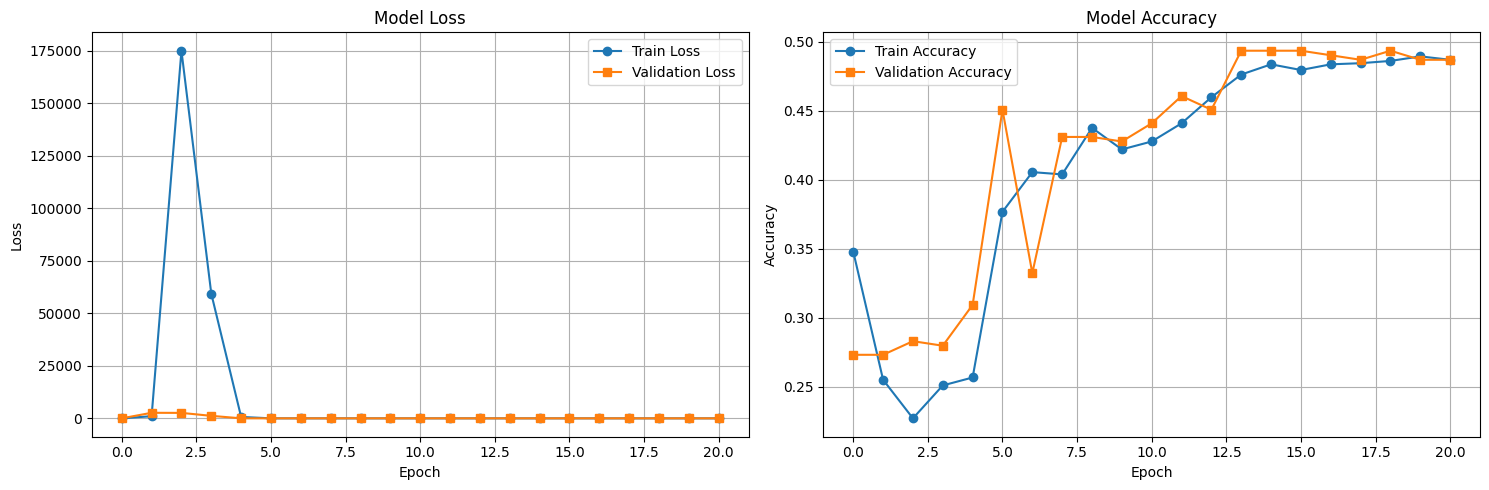

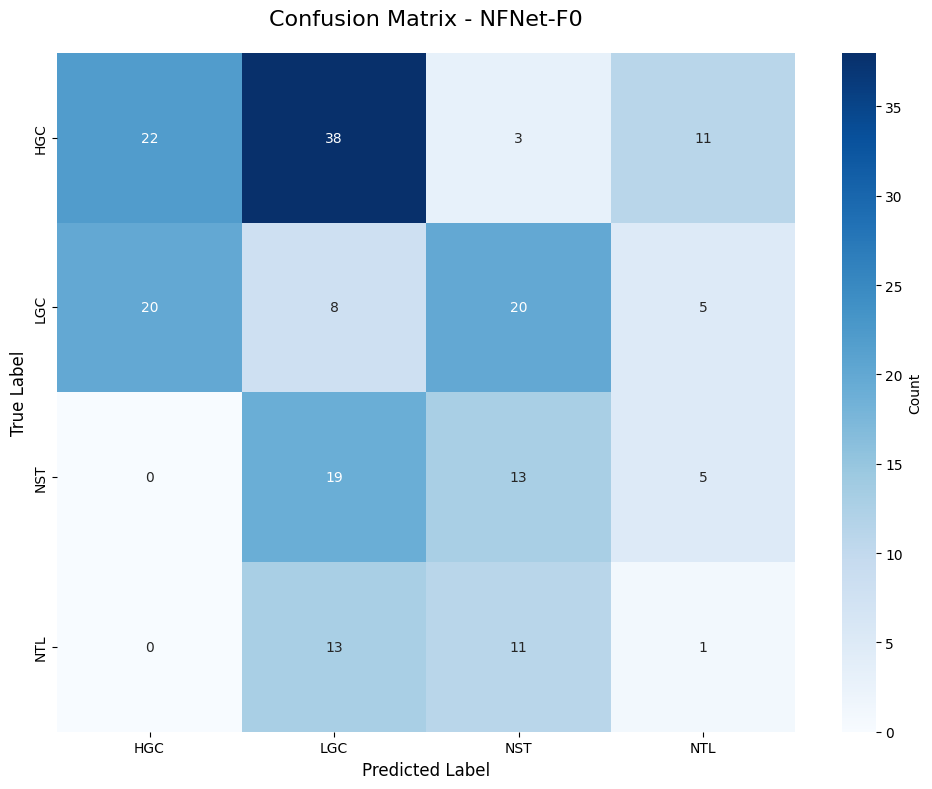

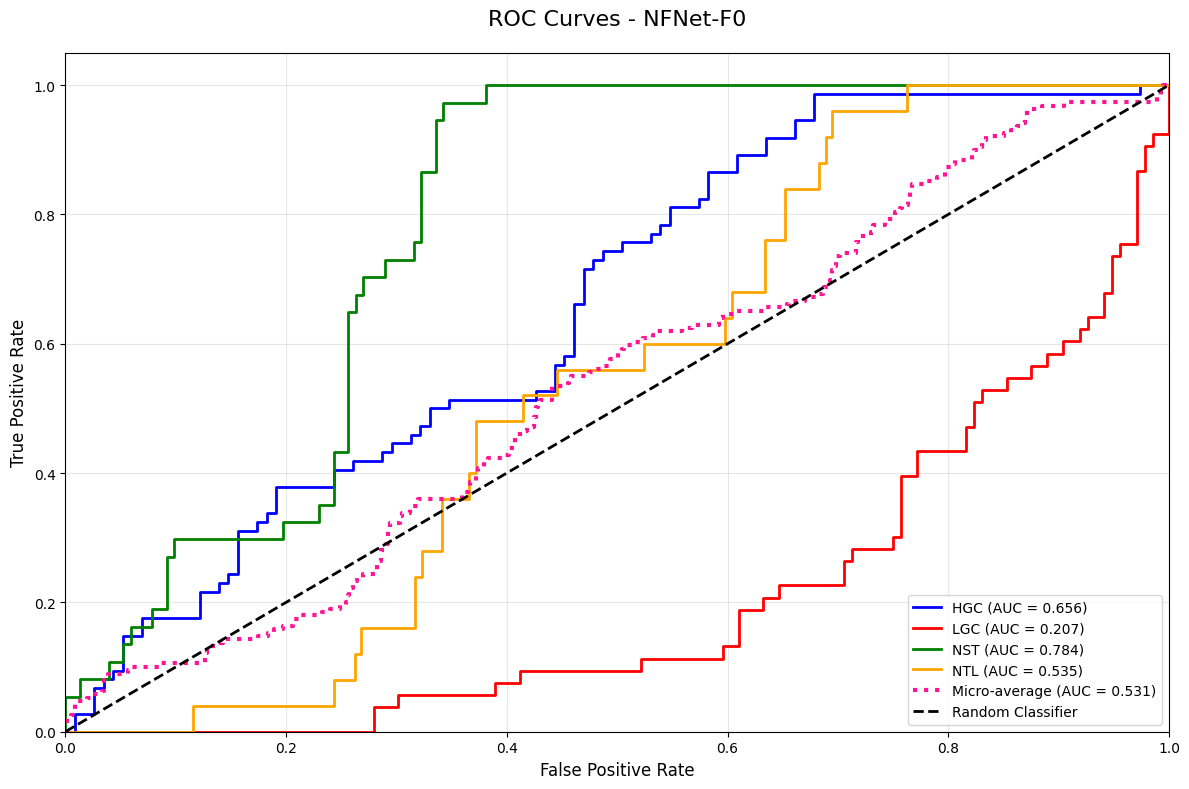


NFNet-F0 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training NFNet-F0 with Imaging Type")
print("=" * 80)

# Create model
nfnet_f0 = NFNetModel(num_classes=4, num_imaging_types=2, model_name='nfnet_f0', pretrained=False)

# Create trainer
trainer_nfnet_f0 = ModelTrainer(nfnet_f0, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_nfnet_f0 = trainer_nfnet_f0.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="NFNet-F0_with_ImagingType")

# Plot training history
trainer_nfnet_f0.plot_training_history(save_path='nfnet_f0_training_history.png')

# Evaluate model
results_nfnet_f0 = trainer_nfnet_f0.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_nfnet_f0['confusion_matrix'], class_names, 'NFNet-F0',
                      save_path='nfnet_f0_confusion_matrix.png')

# Plot ROC curves
roc_auc_nfnet_f0 = plot_roc_curves(results_nfnet_f0['labels'], results_nfnet_f0['probabilities'], class_names, 'NFNet-F0',
                                    save_path='nfnet_f0_roc_curves.png')

# Store results
results_nfnet_f0['model_name'] = 'NFNet-F0'
results_nfnet_f0['roc_auc'] = roc_auc_nfnet_f0
all_results.append(results_nfnet_f0)

print("\nNFNet-F0 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'NFNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: NFNet_metrics.csv

Metrics Summary:
      Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall   HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  NFNet-F0         23.280423       1.75505             0.237106          0.209898      0.213381                0.294012             0.232804         0.248987        0.52381    0.297297  0.37931           74       0.102564    0.150943  0.122137           53       0.276596    0.351351  0.309524           37       0.045455        0.04  0.042553           25   0.545433   0.531069  0.655582  0.207131  0.784139  0.534878      0.655582      0.207131  